In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
import math
import matplotlib.style
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import opto_util as opto

import importlib
plt.rcParams.update({
    'font.sans-serif': 'arial',
    'font.family': 'sans-serif'
})

In [14]:
Penk_xls = pd.ExcelFile('PPR_sheets/Penk_PPRs.xlsx')
Rorb_xls = pd.ExcelFile('PPR_sheets/Rorb_PPRs.xlsx')
Tlx3_xls = pd.ExcelFile('PPR_sheets/Tlx3_PPRs.xlsx')
Sst_xls = pd.ExcelFile('PPR_sheets/Sst_PPRs.xlsx')
Pvalb_xls = pd.ExcelFile('PPR_sheets/Pvalb_PPRs.xlsx')

In [15]:
def PPR_cnx_setISI(cnx_df):
    cnx_df=cnx_df.sort_values(by='sweeps').reset_index(drop=True)
    cnx_df['trial_PPR']=cnx_df['DC2']/cnx_df['DC1']
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['amp_norm']=cnx_df['peaks1']/np.mean(cnx_df['peaks1'][0:5])
    cnx_df_3t7=cnx_df[(cnx_df['trial_ISI']>3) & (cnx_df['trial_ISI']<7)]
    cnx_df_7t13=cnx_df[(cnx_df['trial_ISI']>7) & (cnx_df['trial_ISI']<13)]
    cnx_df_5t10=cnx_df[(cnx_df['trial_ISI']>5) & (cnx_df['trial_ISI']<10)]
    if len(cnx_df_3t7.DC2)>4: ##if at least 5 trials in this window, save average
        PPR_3t7=np.mean(cnx_df_3t7.DC2)/np.mean(cnx_df.DC1)
    else:
        PPR_3t7=float('NaN')
    if len(cnx_df_7t13.DC2)>4: ##if at least 5 trials in this window, save average
        PPR_7t13=np.mean(cnx_df_7t13.DC2)/np.mean(cnx_df.DC1)
    else:  
        PPR_7t13=float('NaN')
    if len(cnx_df_5t10.DC2)>4: ##if at least 5 trials in this window, save average
        PPR_5t10=np.mean(cnx_df_5t10.DC2)/np.mean(cnx_df.DC1)
    else:  
        PPR_5t10=float('NaN')
    m, b = np.polyfit(cnx_df.index, cnx_df.peaks1, 1)
    return {'PPR_3t7':PPR_3t7, 'PPR_7t13':PPR_7t13,'PPR_5t10':PPR_5t10, 'm':m, 'b':b}

def PPR_all(cnx_df, name):
    DC1_mean=np.mean(cnx_df.DC1)
    cnx_df=cnx_df.dropna(subset=['DC2'])
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
    cnx_df=cnx_df.dropna(subset=['DC2'])
    return {name:cnx_df}
    
def SMAQ(amps):  ##statistical moments analysis of quanta as described in Holler et al. 2021 Nature
    u=np.mean(amps)
    sig=np.std(amps)
    gamma=stats.skew(amps)
    trial_n=len(amps)
    N=-1*(u**2)/((gamma*u-sig)*sig)
    P=(gamma*u-sig)/(gamma*u-2*sig)
    Q=(-1*gamma*u*sig+2*sig**2)/u
    #print "N:", N, "P: ", P, "Q: ",Q 
    return {'N':N, 'P':P, 'Q':Q, 'u':u,'sig':sig,'gamma':gamma,'trial_n':trial_n}



In [16]:
def PDR_cnx_setISI(cnx_df): ##paired depolarization ratio, combined PSP amplitude/amplitude of 1st PSP, 
    cnx_df['trial_PDR']=cnx_df['peaks2']/cnx_df['peaks1']
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['amp_norm']=cnx_df['peaks1']/np.mean(cnx_df['peaks1'][0:5])
    cnx_df_3t7=cnx_df[(cnx_df['trial_ISI']>3) & (cnx_df['trial_ISI']<7)]
    cnx_df_7t13=cnx_df[(cnx_df['trial_ISI']>7) & (cnx_df['trial_ISI']<13)]
    cnx_df_5t10=cnx_df[(cnx_df['trial_ISI']>5) & (cnx_df['trial_ISI']<10)]
    if len(cnx_df_3t7.peaks2)>4: ##if at least 5 trials in this window, save average
        PDR_3t7=np.mean(cnx_df_3t7.peaks2)/np.mean(cnx_df.peaks1)
    else:
        PDR_3t7=float('NaN')
    if len(cnx_df_7t13.peaks2)>4: ##if at least 5 trials in this window, save average
        PDR_7t13=np.mean(cnx_df_7t13.peaks2)/np.mean(cnx_df.peaks1)
    else:  
        PDR_7t13=float('NaN')
    if len(cnx_df_5t10.peaks2)>4: ##if at least 5 trials in this window, save average
        PDR_5t10=np.mean(cnx_df_5t10.peaks2)/np.mean(cnx_df.peaks1)
    else:  
        PDR_5t10=float('NaN')
    return {'PDR_3t7':PDR_3t7, 'PDR_7t13':PDR_7t13,'PDR_5t10':PDR_5t10}


In [17]:
def make_summary_df(xls):
    df_map = {}
    dict_of_dfs={}
    for sheet_name in xls.sheet_names:
        df_map[sheet_name] = xls.parse(sheet_name)

    cnx_dict_list=[]
    PPR_cnxs=df_map.keys()
    cnx_dict={}
    for cnx in PPR_cnxs:
        cnx_dict={'name':cnx}
        cnx_df=df_map[cnx]
        PPR_vals=PPR_cnx_setISI(cnx_df)
        PDR_vals=PDR_cnx_setISI(cnx_df)
        cnx_dict.update(PPR_vals)
        cnx_dict.update(PDR_vals)
        out_cnxs=PPR_all(cnx_df,cnx)
        dict_of_dfs.update(out_cnxs)
        SMAQ_dict=SMAQ(cnx_df.peaks1)
        cnx_dict.update(SMAQ_dict)
        cnx_dict_list.append(cnx_dict)

    summary_df=pd.DataFrame(cnx_dict_list)
    summary_df['exp_id']=summary_df.name.str[0:18]
    summary_df['MP_ID']='temp'
    summary_df['headstage']=0

    for i in summary_df.index:
        PS_name=str.split(str(summary_df.name[i]),'_')[5]
        if PS_name.startswith('T'):
            T_name_split=str.split(PS_name)
            T_round=T_name_split[0][1:]
            T_stim=T_name_split[1]
            full_name="TSeries_"+T_round+"_"+T_stim
            summary_df['MP_ID'][i]=full_name
        else:
            summary_df['MP_ID'][i]='Point '+str.split(str(summary_df.name[i]),'_')[5]
        summary_df['headstage'][i]=int(summary_df.name[i][-1:])
    return summary_df, dict_of_dfs

In [18]:
full_df=pd.read_csv('data/full_df.csv')

In [19]:
Penk_summary_df, Penk_cnx_dict=make_summary_df(Penk_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/3435796388.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [20]:
Penk_summary_df

,name,PPR_3t7,PPR_7t13,PPR_5t10,m,b,PDR_3t7,PDR_7t13,PDR_5t10,N,P,Q,u,sig,gamma,trial_n,exp_id,MP_ID,headstage
0,2020_08_21_exp1_TH_38_AD1,1.833041,1.768586,1.836112,0.007135,0.256279,3.363080,2.840986,3.066409,-3.810801,-0.784209,0.108436,0.324057,0.250392,1.112292,20,2020_08_21_exp1_TH,Point 38,1
1,2020_08_21_exp1_TH_28_AD1,1.676419,1.038435,1.201345,0.000757,0.246673,3.022709,2.082588,2.518311,-31.338981,-0.030940,0.260645,0.252733,0.260599,1.062070,17,2020_08_21_exp1_TH,Point 28,1
2,2020_08_21_exp1_TH_27_AD3,1.764614,1.330705,1.619977,0.007069,1.362170,2.303102,2.117486,2.241230,17.681666,0.140741,0.574366,1.429329,0.839890,0.491364,20,2020_08_21_exp1_TH,Point 27,3
3,2020_08_21_exp1_TH_21_AD3,NaN,1.509063,1.774447,0.135427,2.858280,NaN,1.941761,2.167864,-3.178614,36.821549,-0.035413,4.144841,2.293032,1.121895,20,2020_08_21_exp1_TH,Point 21,3
4,2020_08_21_exp1_TH_18_AD3,1.363880,1.029911,1.200544,-0.114323,4.035414,1.996056,1.665407,1.860104,2.758735,0.551743,1.937663,2.949343,1.600535,-0.125284,20,2020_08_21_exp1_TH,Point 18,3
5,2020_11_12_exp2_TH_30_AD3,1.129129,0.971834,1.065129,-0.039190,6.033702,1.933110,1.815177,1.916167,5.099799,0.530371,2.020659,5.465448,2.277387,-0.053895,30,2020_11_12_exp2_TH,Point 30,3
6,2020_11_12_exp2_TH_29_AD3,NaN,0.490759,0.528757,0.015215,2.199350,NaN,1.263650,1.261480,2.096601,0.599204,2.089768,2.625359,1.482876,-0.279610,57,2020_11_12_exp2_TH,Point 29,3
7,2020_11_12_exp2_TH_13_AD3,0.739820,0.924256,0.933393,-0.001473,0.709457,2.092715,1.780562,2.546023,4.211445,0.149459,1.095525,0.689567,0.801580,0.958173,28,2020_11_12_exp2_TH,Point 13,3
8,2020_07_31_exp2_TH_13_AD0,1.251592,NaN,1.241207,0.001835,0.303110,2.180923,NaN,2.109761,-3.037466,-1.450236,0.076725,0.337976,0.252066,1.187239,39,2020_07_31_exp2_TH,Point 13,0
9,2020_07_30_exp2_TH_20_AD3,1.077948,0.849589,0.959494,0.000902,0.163437,2.115867,1.515167,2.022583,11.175577,0.102491,0.168670,0.193194,0.171016,0.784117,67,2020_07_30_exp2_TH,Point 20,3


In [23]:
Penk_master_isi=[]
Penk_master_PPR=[]
for key in Penk_cnx_dict:
    df=Penk_cnx_dict[key]
    df=df[df.trial_ISI>2]
    Penk_master_isi.extend(np.array(df.trial_ISI))
    Penk_master_PPR.extend(np.array(df.trial_PPR_avg))


Text(0, 0.5, 'PPR')

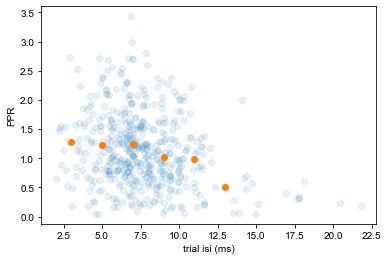

In [27]:
##manuscript focuses on isi's 5-10 ms. Choice was made based on common occurence of PSPs with this interval.
##Possible to explore data at other intervals.
bins=np.arange(2,16,2)
plt.scatter(Penk_master_isi, Penk_master_PPR,alpha=0.1)
Penk_binned_mean=stats.binned_statistic(Penk_master_isi, Penk_master_PPR, bins=bins, statistic='mean')[0]
plt.scatter(opto.midPoints(bins), Penk_binned_mean)
plt.xlabel('trial isi (ms)')
plt.ylabel('PPR')

In [28]:
Rorb_summary_df, Rorb_cnx_dict=make_summary_df(Rorb_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/3435796388.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [29]:
Rorb_master_isi=[]
Rorb_master_PPR=[]
for key in Rorb_cnx_dict:
    df=Rorb_cnx_dict[key]
    df=df[df.trial_ISI>2]

    Rorb_master_isi.extend(np.array(df.trial_ISI))
    Rorb_master_PPR.extend(np.array(df.trial_PPR_avg))


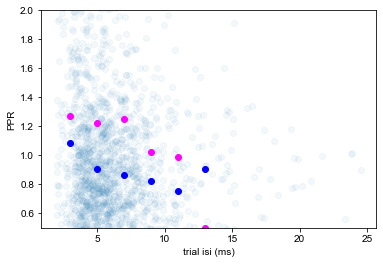

In [30]:
#bins=np.arange(2,25,2)
plt.scatter(Rorb_master_isi, Rorb_master_PPR,alpha=0.051)
Rorb_binned_mean=stats.binned_statistic(Rorb_master_isi, Rorb_master_PPR, bins=bins, statistic='mean')[0]
plt.scatter(opto.midPoints(bins), Rorb_binned_mean,c='blue')
plt.scatter(opto.midPoints(bins), Penk_binned_mean,c='magenta')
plt.ylim([0.5,2])
plt.xlabel('trial isi (ms)')
plt.ylabel('PPR')
plt.show()

In [31]:
Tlx3_summary_df, Tlx3_cnx_dict=make_summary_df(Tlx3_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/3435796388.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [32]:
Tlx3_master_isi=[]
Tlx3_master_PPR=[]
for key in Tlx3_cnx_dict:
    df=Tlx3_cnx_dict[key]
    df=df[df.trial_ISI>2]
    Tlx3_master_isi.extend(np.array(df.trial_ISI))
    Tlx3_master_PPR.extend(np.array(df.trial_PPR_avg))

plt.show()

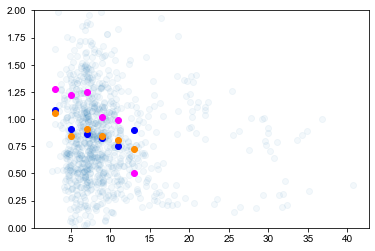

In [33]:
#bins=np.arange(2,25,2)
plt.scatter(Tlx3_master_isi, Tlx3_master_PPR,alpha=0.051)
Tlx3_binned_mean=stats.binned_statistic(Tlx3_master_isi, Tlx3_master_PPR, bins=bins, statistic='mean')[0]
plt.scatter(opto.midPoints(bins), Rorb_binned_mean,c='blue')
plt.scatter(opto.midPoints(bins), Penk_binned_mean,c='magenta')
plt.scatter(opto.midPoints(bins), Tlx3_binned_mean,c='darkorange')

plt.ylim([0,2])
plt.show()

In [34]:
Pvalb_summary_df,Pvalb_cnx_dict=make_summary_df(Pvalb_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/3435796388.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [35]:
Sst_summary_df,Sst_cnx_dict=make_summary_df(Sst_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/533149816.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_92776/3435796388.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [36]:
full_ppr_df=pd.concat([Penk_summary_df, Rorb_summary_df, Tlx3_summary_df, Pvalb_summary_df, Sst_summary_df])
print (np.shape(full_ppr_df))

(257, 19)


In [37]:
full_ppr_df

,name,PPR_3t7,PPR_7t13,PPR_5t10,m,b,PDR_3t7,PDR_7t13,PDR_5t10,N,P,Q,u,sig,gamma,trial_n,exp_id,MP_ID,headstage
0,2020_08_21_exp1_TH_38_AD1,1.833041,1.768586,1.836112,0.007135,0.256279,3.363080,2.840986,3.066409,-3.810801,-0.784209,0.108436,0.324057,0.250392,1.112292,20,2020_08_21_exp1_TH,Point 38,1
1,2020_08_21_exp1_TH_28_AD1,1.676419,1.038435,1.201345,0.000757,0.246673,3.022709,2.082588,2.518311,-31.338981,-0.030940,0.260645,0.252733,0.260599,1.062070,17,2020_08_21_exp1_TH,Point 28,1
2,2020_08_21_exp1_TH_27_AD3,1.764614,1.330705,1.619977,0.007069,1.362170,2.303102,2.117486,2.241230,17.681666,0.140741,0.574366,1.429329,0.839890,0.491364,20,2020_08_21_exp1_TH,Point 27,3
3,2020_08_21_exp1_TH_21_AD3,NaN,1.509063,1.774447,0.135427,2.858280,NaN,1.941761,2.167864,-3.178614,36.821549,-0.035413,4.144841,2.293032,1.121895,20,2020_08_21_exp1_TH,Point 21,3
4,2020_08_21_exp1_TH_18_AD3,1.363880,1.029911,1.200544,-0.114323,4.035414,1.996056,1.665407,1.860104,2.758735,0.551743,1.937663,2.949343,1.600535,-0.125284,20,2020_08_21_exp1_TH,Point 18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2018_12_11_exp1_TH_5_AD2,1.217565,1.167996,1.237882,0.003197,-0.282085,2.306409,1.945776,2.161224,8.518785,0.479193,-0.062054,-0.253312,0.090479,-0.028541,19,2018_12_11_exp1_TH,Point 5,2
85,2018_11_15_exp2_TH_T73 1_AD1,0.889425,0.630196,0.798048,-0.004039,-0.260890,1.695819,1.053528,1.447279,2.933809,0.535808,-0.205786,-0.323488,0.175787,0.083839,32,2018_11_15_exp2_TH,TSeries_73_1,1
86,2018_11_15_exp2_TH_T73 1_AD3,1.067784,0.744524,1.020186,-0.004766,-0.254527,2.087224,1.887062,2.045606,9.751895,0.321396,-0.110102,-0.345085,0.160572,-0.244934,39,2018_11_15_exp2_TH,TSeries_73_1,3
87,2018_11_13_exp2_TH_T33 1_AD1,NaN,NaN,NaN,-0.000588,-0.610914,NaN,NaN,NaN,4.795278,0.528420,-0.243184,-0.616209,0.265833,0.051997,19,2018_11_13_exp2_TH,TSeries_33_1,1


In [38]:
full_df = pd.merge(full_df,full_ppr_df, how='left', left_on=['exp_id', 'headstage', 'MP_ID'], right_on=['exp_id', 'headstage', 'MP_ID'])


In [39]:
standard_df=full_df[full_df.internal=='standard']
standard_df=standard_df[standard_df.notes.isnull()]
RorbAi167=standard_df[(standard_df.presynapticCre=='Rorb') & (standard_df.presynapticEffector=='Ai167')]
RorbKv=standard_df[(standard_df.presynapticCre=='Rorb') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
SstAi167=standard_df[(standard_df.presynapticCre=='Sst') & (standard_df.presynapticEffector=='Ai167')]
SstKv=standard_df[(standard_df.presynapticCre=='Sst') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
PvalbKv=standard_df[(standard_df.presynapticCre=='Pvalb') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
PenkKv=standard_df[(standard_df.presynapticCre=='Penk') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Tlx3Kv=standard_df[(standard_df.presynapticCre=='Tlx3') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Scnn1aAi167=standard_df[(standard_df.presynapticCre=='Scnn1a') & (standard_df.presynapticEffector=='Ai167')]
Cux2Kv=standard_df[(standard_df.presynapticCre=='Cux2') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Cux2ERKv=standard_df[(standard_df.presynapticCre=='Cux2-ERT2') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Sst=standard_df[standard_df.presynapticCre=='Sst']
Ntsr1=standard_df[standard_df.presynapticCre=='Ntsr1']
Rorb=standard_df[standard_df.presynapticCre=='Rorb']
Scnn1a=standard_df[standard_df.presynapticCre=='Scnn1a']
Sst=standard_df[standard_df.presynapticCre=='Sst']


exc_L23_pyr=standard_df[(standard_df.post_class=='pyramidal') & (standard_df.post_layer==2)]
exc_L23_pyr=exc_L23_pyr[exc_L23_pyr.presynapticCre.isin(['Penk', 'Scnn1a', 'Rorb', 'Tlx3', 'Ntsr1'])]
exc_L23_fsi=standard_df[(standard_df.Kcluster==1) & (standard_df.post_layer==2)]
exc_L23_fsi=exc_L23_fsi[exc_L23_fsi.presynapticCre.isin(['Penk', 'Scnn1a', 'Rorb', 'Tlx3', 'Ntsr1'])]



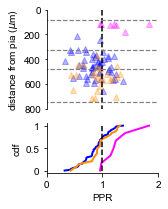

In [43]:
tick_size=2
label_size=10
fs=10
markersize=20
PPR_lim=[0,2]

pyr=full_df[(full_df.post_class=='pyramidal') & (full_df.post_layer==2)]
pyr=pyr.dropna(subset=['PPR_5t10'])
Penk_pyr=pyr[pyr.presynapticCre=='Penk']
Rorb_pyr=pyr[pyr.presynapticCre=='Rorb']
Tlx3_pyr=pyr[pyr.presynapticCre=='Tlx3']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)
gs = matplotlib.gridspec.GridSpec(2,1, **gskw)

fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)

df_list=[Penk_pyr,Rorb_pyr,Tlx3_pyr]
colors=['magenta','blue','darkorange']

for df, color in zip(df_list, colors):
    ax0.scatter(df.PPR_5t10, df.y_pia, c=color, marker='^',alpha=0.3)
    opto.plot_cdf(ax1,df.PPR_5t10,color=color)
    
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])

for ax in [ax0,ax1]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(PPR_lim)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.yaxis.set_ticks([0,0.5,1])
plt.xlabel('PPR',fontsize=fs)
plt.show()

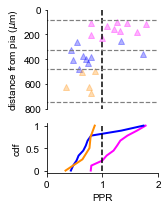

In [46]:
label_size=10
fs=10
markersize=20
PPR_lim=[0,2]

inter=full_df[(full_df.Kcluster==1) & (full_df.post_layer==2)]
inter=inter.dropna(subset=['PPR_5t10'])
Penk_inter=inter[inter.presynapticCre=='Penk']
Rorb_inter=inter[inter.presynapticCre=='Rorb']
Tlx3_inter=inter[inter.presynapticCre=='Tlx3']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)
gs = matplotlib.gridspec.GridSpec(2,1, **gskw)

fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
df_list=[Penk_inter,Rorb_inter,Tlx3_inter]
colors=['magenta','blue','darkorange']

for df, color in zip(df_list, colors):
    ax0.scatter(df.PPR_5t10, df.y_pia, c=color, marker='^',alpha=0.3)
    opto.plot_cdf(ax1,df.PPR_5t10,color=color)
    
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])

for ax in [ax0,ax1]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(PPR_lim)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.yaxis.set_ticks([0,0.5,1])
plt.xlabel('PPR',fontsize=fs)
plt.show()

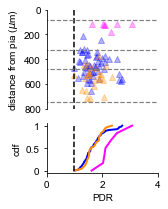

In [45]:
##data can also be analyzed by paired depolarization ratio - summed PSP amplitude at the peak of
##the 2nd PSP:amplitude of the first PSP. These values will be influenced by the membrane time constant of the cell.
tick_size=2
label_size=10
fs=10
markersize=20
PDR_lim=[0,4]

gskw = dict(height_ratios=[1,0.5], wspace=0.08)
gs = matplotlib.gridspec.GridSpec(2,1, **gskw)

fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)

df_list=[Penk_pyr,Rorb_pyr,Tlx3_pyr]
colors=['magenta','blue','darkorange']

for df, color in zip(df_list, colors):
    ax0.scatter(df.PDR_5t10, df.y_pia, c=color, marker='^',alpha=0.3)
    opto.plot_cdf(ax1,df.PDR_5t10,color=color)
    
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])

for ax in [ax0,ax1]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(PDR_lim)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.yaxis.set_ticks([0,0.5,1])
plt.xlabel('PDR',fontsize=fs)
plt.show()

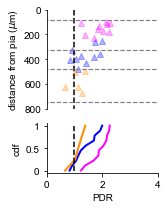

In [58]:
##data can also be analyzed by paired depolarization ratio - summed PSP amplitude at the peak of
##the 2nd PSP:amplitude of the first PSP. These values will be influenced by the membrane time constant of the cell.
tick_size=2
label_size=10
fs=10
markersize=20
PDR_lim=[0,4]

gskw = dict(height_ratios=[1,0.5], wspace=0.08)
gs = matplotlib.gridspec.GridSpec(2,1, **gskw)

fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)

df_list=[Penk_inter,Rorb_inter,Tlx3_inter]
colors=['magenta','blue','darkorange']

for df, color in zip(df_list, colors):
    ax0.scatter(df.PDR_5t10, df.y_pia, c=color, marker='^',alpha=0.3)
    opto.plot_cdf(ax1,df.PDR_5t10,color=color)
    
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])

for ax in [ax0,ax1]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(PDR_lim)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.yaxis.set_ticks([0,0.5,1])
plt.xlabel('PDR',fontsize=fs)
plt.show()

m, b:  0.4241832339641844 0.6815766763954375
(0.45831936200172735, 1.164932857854954e-05)


SpearmanrResult(correlation=0.46194188518781004, pvalue=9.725214323426574e-06)

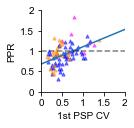

In [55]:
df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr]
colors=['magenta', 'blue', 'darkorange']
fig, ax=plt.subplots()
for df, color in zip(df_list, colors):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker='^',alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b)
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,2])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
stats.spearmanr(cat_df.CV, cat_df.PPR_5t10)


m, b:  0.6805445326232573 0.5018902361480536
(0.4051482710897895, 0.04452374053767795)
SpearmanrResult(correlation=0.4746153846153846, pvalue=0.01651925246500725)


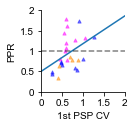

In [56]:
df_list=[Penk_inter, Rorb_inter, Tlx3_inter]

colors=['magenta', 'blue', 'darkorange']
fig, ax=plt.subplots()
for df, color in zip(df_list, colors):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker='^',alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b)
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,2])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))


m, b:  0.4658291569543052 0.6550498806321727
(0.42921637515863853, 3.2089788000476446e-06)
SpearmanrResult(correlation=0.44434250764525995, pvalue=1.2975545566588366e-06)


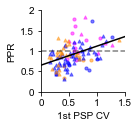

In [57]:
df_list=[Penk_inter, Rorb_inter, Tlx3_inter,Penk_pyr, Rorb_pyr, Tlx3_pyr]

colors=['magenta', 'blue', 'darkorange','magenta', 'blue', 'darkorange']
markers=['o','o','o','^','^','^']
fig, ax=plt.subplots()
for df, color,marker in zip(df_list, colors,markers):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker=marker,alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b,c='black')
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,1.5])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))


In [59]:


df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr, Penk_inter, Rorb_inter, Tlx3_inter]
colors=['magenta', 'darkblue','darkorange', 'pink', 'skyblue','orange' ]
cnx_classes=['Penk to PC','Rorb to PC', 'Tlx3 to PC', 'Penk to FSI', 'Rorb to FSI', 'Tlx3 to FSI']
PPR_master=[]
i=0
summary_table=np.zeros([len(cnx_classes),4])
for df,color in zip(df_list,colors):
    df=df.dropna(subset=['PPR_5t10'])
    class_name=cnx_classes[i]    
    median=np.median(df.PPR_5t10)
    mean=np.mean(df.PPR_5t10)
    sd=np.std(df.PPR_5t10)
    n=len(df.PPR_5t10)
    skew=stats.skew(df.PPR_5t10)
    print (class_name, median, mean ,sd, skew)
    summary_table[i,:]=np.array([median, mean, sd, skew])
    PPR_master.append(np.array(df.PPR_5t10))
    i+=1


Penk to PC 1.2013453884738519 1.2528571825620367 0.27727402220161995 1.040075431326663
Rorb to PC 0.8743621345902155 0.8660403411855495 0.2301223394291963 -0.16761265459698907
Tlx3 to PC 0.9117092050897229 0.9188431978563485 0.24127286386845978 -0.31155030573995157
Penk to FSI 1.2321728855986307 1.2299502898047474 0.30965475019444627 0.18102635462058847
Rorb to FSI 0.6804743045494419 0.7993553845820722 0.3949671546657078 1.4051481851084953
Tlx3 to FSI 0.7687461623768658 0.6805743597901543 0.18462778891690323 -1.0085999011974704


In [60]:
args=[l for l in PPR_master]
stats.kruskal(*args)

KruskalResult(statistic=24.574543731497783, pvalue=0.0001683154743834123)

In [62]:
import scikit_posthocs as sp
import seaborn as sns
def Cohens_d(pop1,pop2):
    u1=np.mean(pop1)
    u2=np.mean(pop2)
    s=np.std(np.append(pop1,pop2))
    s1=np.std(pop1)
    s2=np.std(pop2)
    d=(u2-u1)/((0.5*(s1**2+s2**2)))**0.5
    return d

In [63]:
count=len(df_list)
out_array=np.zeros([count,count])
y_array=range(count)
x_array=range(count)
i=0
for y in y_array:
    x_array=range(0,count)
    for x in x_array:
        d=Cohens_d(args[x],args[y])
        out_array[x,y]=d
    i+=1

In [64]:
out_array[out_array == 0] ='nan'
cnx_classes

['Penk to PC',
 'Rorb to PC',
 'Tlx3 to PC',
 'Penk to FSI',
 'Rorb to FSI',
 'Tlx3 to FSI']

In [65]:
exc_dunn=sp.posthoc_dunn(args,p_adjust='fdr_bh')
exc_dunn

,1,2,3,4,5,6
1,1.000000,0.007896,0.044519,0.706233,0.004128,0.004128
2,0.007896,1.000000,0.431526,0.007896,0.226986,0.137575
3,0.044519,0.431526,1.000000,0.059777,0.105194,0.074118
4,0.706233,0.007896,0.059777,1.000000,0.004128,0.004128
5,0.004128,0.226986,0.105194,0.004128,1.000000,0.616393
6,0.004128,0.137575,0.074118,0.004128,0.616393,1.000000


([<matplotlib.axis.YTick at 0x7ff1ad977490>,
 [Text(0, 0.5, 'Penk to PC'),
  Text(0, 1.5, 'Rorb to PC'),
  Text(0, 2.5, 'Tlx3 to PC'),
  Text(0, 3.5, 'Penk to FSI'),
  Text(0, 4.5, 'Rorb to FSI'),
  Text(0, 5.5, 'Tlx3 to FSI')])

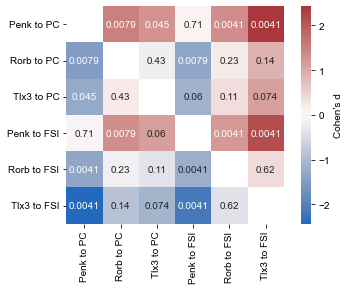

In [66]:
x_ticks=np.arange(0.5,count+0.4,1)
sns.heatmap(np.transpose(out_array),cmap='vlag',square=True, annot=exc_dunn, cbar_kws={'label': "Cohen's d"})
plt.xticks(x_ticks, cnx_classes, rotation='vertical')
plt.yticks(x_ticks, cnx_classes, rotation='horizontal')
#plt.savefig('exc_PPR_CohenDunn_table.svg')

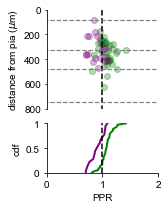

In [59]:

tick_size=2
label_size=10
fs=10
markersize=20

PPR_lim=[0,2]
df=standard_df
df=df[df.post_layer==2]
pyr=df[df.post_class=='pyramidal']
pyr=pyr.dropna(subset=['PPR_5t10'])
Sst_pyr=pyr[pyr.presynapticCre=='Sst']
Pvalb_pyr=pyr[pyr.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_pyr.PPR_5t10, Sst_pyr.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_pyr.PPR_5t10, Pvalb_pyr.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PPR_lim)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PPR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_pyr.PPR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_pyr.PPR_5t10,color='green')

ax1.set_ylim([0,1])

ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


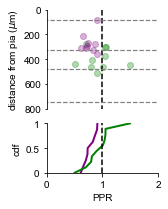

In [60]:

tick_size=2
label_size=10
fs=10
markersize=20

PPR_lim=[0,2]
df=standard_df
df=df[df.post_layer==2]
inter=df[df.Kcluster==1]
inter=inter.dropna(subset=['PPR_5t10'])
Sst_inter=inter[inter.presynapticCre=='Sst']
Pvalb_inter=inter[inter.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_inter.PPR_5t10, Sst_inter.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_inter.PPR_5t10, Pvalb_inter.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PPR_lim)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PPR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_inter.PPR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_inter.PPR_5t10,color='green')

ax1.set_ylim([0,1])

ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


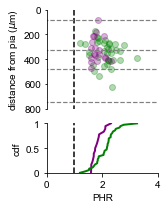

In [61]:

tick_size=2
label_size=10
fs=10
markersize=20

PDR_lim=[0,4]
df=standard_df
df=df[df.post_layer==2]
pyr=df[df.post_class=='pyramidal']
pyr=pyr.dropna(subset=['PDR_5t10'])
Sst_pyr=pyr[pyr.presynapticCre=='Sst']
Pvalb_pyr=pyr[pyr.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_pyr.PDR_5t10, Sst_pyr.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_pyr.PDR_5t10, Pvalb_pyr.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PDR_lim)
Sst_med=np.nanmedian(Sst_pyr.PDR_5t10)
Sst_mean=np.nanmean(Sst_pyr.PDR_5t10)
Pvalb_med=np.nanmedian(Pvalb_pyr.PDR_5t10)
Pvalb_mean=np.nanmean(Pvalb_pyr.PDR_5t10)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
#ax0.set_xscale('log', basex=10)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PHR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_pyr.PDR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_pyr.PDR_5t10,color='green')

ax1.set_ylim([0,1])
#ax1.set_xlim(PDR_lim)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


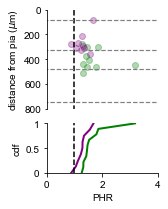

In [62]:

tick_size=2
label_size=10
fs=10
markersize=20

PDR_lim=[0,4]
df=standard_df
df=df[df.post_layer==2]
inter=df[df.Kcluster==1]
inter=inter.dropna(subset=['PDR_5t10'])
Sst_inter=inter[inter.presynapticCre=='Sst']
Pvalb_inter=inter[inter.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_inter.PDR_5t10, Sst_inter.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_inter.PDR_5t10, Pvalb_inter.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PDR_lim)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PHR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_inter.PDR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_inter.PDR_5t10,color='green')

ax1.set_ylim([0,1])
ax1.set_xlim(PDR_lim)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


In [64]:

df_list=[Pvalb_pyr, Sst_pyr, Pvalb_inter, Sst_inter]
colors=['purple', 'green','purple', 'green']
cnx_classes=['Pvalb to PC','Sst to PC', 'Pvalb to FSI', 'Sst to FSI']
PPR_master=[]
i=0
summary_table=np.zeros([len(cnx_classes),4])
for df,color in zip(df_list,colors):
    df=df.dropna(subset=['PPR_5t10'])


    class_name=cnx_classes[i]
    
    median=np.median(df.PPR_5t10)
    mean=np.mean(df.PPR_5t10)
    sd=np.std(df.PPR_5t10)
    n=len(df.PPR_5t10)
    skew=stats.skew(df.PPR_5t10)

    print (class_name, median, mean ,sd, skew)

    summary_table[i,:]=np.array([median, mean, sd, skew])
    PPR_master.append(np.array(df.PPR_5t10))

    i+=1


Pvalb to PC 0.8997638203918015 0.8992404633880083 0.12499817310445467 -0.13807780077663373
Sst to PC 1.0686429529476225 1.074051286543698 0.11671808396662454 0.39890159252262164
Pvalb to FSI 0.73599944710595 0.7720786452400823 0.10305259584514187 -0.011859736594611136
Sst to FSI 0.9539735926929829 0.9373536896495478 0.2519311199038911 0.4897288625870018


In [66]:
args=[l for l in PPR_master]
print (stats.kruskal(*args))
count=len(df_list)
out_array=np.zeros([count,count])
y_array=range(count)
x_array=range(count)
i=0
for y in y_array:
    x_array=range(0,count)
    for x in x_array:
        d=Cohens_d(args[x],args[y])
        out_array[x,y]=d
    i+=1

KruskalResult(statistic=30.837203863142918, pvalue=9.198531397974321e-07)


In [67]:
out_array[out_array == 0] ='nan'
exc_dunn=sp.posthoc_dunn(args,p_adjust='fdr_bh')
exc_dunn

,1,2,3,4
1,1.000000,0.000286,0.128531,0.565806
2,0.000286,1.000000,0.000014,0.027712
3,0.128531,0.000014,1.000000,0.084712
4,0.565806,0.027712,0.084712,1.000000


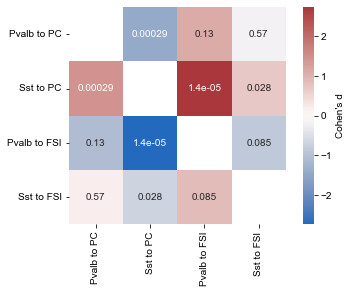

In [68]:
x_ticks=np.arange(0.5,count+0.5,1)
sns.heatmap(np.transpose(out_array),cmap='vlag',square=True, annot=exc_dunn, cbar_kws={'label': "Cohen's d"})
plt.xticks(x_ticks, cnx_classes, rotation='vertical')
plt.yticks(x_ticks, cnx_classes, rotation='horizontal')

#plt.savefig('inh_PPR_CohenDunntable.svg')

m, b:  0.22522818947216872 0.8338337844778174
(0.31101085374827286, 0.006609546422770123)
SpearmanrResult(correlation=0.35780938833570414, pvalue=0.0016231230020293818)


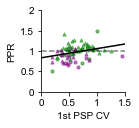

In [69]:
df_list=[Pvalb_inter, Sst_inter, Pvalb_pyr, Sst_pyr]

colors=['purple', 'green', 'purple','green']
markers=['o','o','^','^']
fig, ax=plt.subplots()
for df, color,marker in zip(df_list, colors,markers):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker=marker,alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b,c='black')
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,1.5])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))
plt.show()
#plt.savefig('inh_to_all_PPRvCV.svg')